In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
    INDEX_TO_SCENARIO
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_metadata_artefacts,
    load_odds,
    join_metadata,
    build_empty_dataframe,
    apply_final_treatment,
)
from GameProbs import GameProbs
from dependencies.utils import get_scenarios
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
metadata, gameid_to_outcome = load_metadata_artefacts("data/metadata-with-date.parquet")
odds = load_odds("data/odds.parquet")
print(metadata.shape)
print(odds.shape)

(16869, 9)
(2003933, 7)


In [ ]:
# import pickle
# games_ids = list(set(odds['GameId']))
# with open('games_ids.pickle','wb') as f:
#     pickle.dump(games_ids, f)

## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [3]:
metadata[metadata.GameId=='4698337']

,League,GameId,Home,Away,Home_score,Away_score,Round,Datetime,Outcome
525,Brasileirão Série A,4698337,Flamengo,Goiás,2,1,Rodada 11,2020-10-13,2 : 1


In [4]:
GAME_ID = "4698337" # Chapecoense x Flamengo
my_game = GameProbs(GAME_ID) 
df = my_game.build_dataframe()
df

,0,1,2,3,4,5,6
0,0.0409,0.0921,0.1113,0.0938,0.0619,0.0340,0.0270
1,0.0264,0.0656,0.0818,0.0718,0.0491,0.0279,0.0232
2,0.0097,0.0249,0.0334,0.0294,0.0206,0.0120,0.0103
3,0.0026,0.0069,0.0093,0.0090,0.0061,0.0036,0.0032
4,0.0006,0.0015,0.0021,0.0020,0.0016,0.0009,0.0008
5,0.0001,0.0003,0.0004,0.0004,0.0003,0.0002,0.0002
6,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001


In [5]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet',
                   'Megapari Sport',
                   '22Bet',
                   'Betfair',
                   '888sport',
                   'Betway',
                   '1xBit',
                   'Marathonbet',
                   'NetBet',
                   'Betobet',
                   '18Bet',
                   'Mr Green Sport',
                   'Parimatch',
                   'Bet365']
#odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]
#odds_sample = odds[(odds.GameId==GAME_ID)]

# Join metadata info to the odds dataframe
odds = join_metadata(odds, metadata)
print(odds.shape)

(2003933, 10)


In [9]:
odds.head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime
0,2738735,Bet365,h2h,,home,1.72,0.581395,São Paulo,Botafogo,2019-04-27
1,2738735,Bet365,h2h,,draw,3.50,0.285714,São Paulo,Botafogo,2019-04-27
2,2738735,Bet365,h2h,,away,4.75,0.210526,São Paulo,Botafogo,2019-04-27
3,2738735,Bet365,over/under,0.5,over,1.08,0.925926,São Paulo,Botafogo,2019-04-27
4,2738735,Bet365,over/under,0.5,under,8.00,0.125000,São Paulo,Botafogo,2019-04-27


In [8]:
for odds_grouped in odds.groupby("GameId"):
    a , b = odds_grouped
    print(a)
    print(b)
    print("-----------")

2738735
      GameId Sportsbook      Market Scenario    Bet     Odd  public_prob  \
0    2738735     Bet365         h2h            home    1.72     0.581395   
1    2738735     Bet365         h2h            draw    3.50     0.285714   
2    2738735     Bet365         h2h            away    4.75     0.210526   
3    2738735     Bet365  over/under      0.5   over    1.08     0.925926   
4    2738735     Bet365  over/under      0.5  under    8.00     0.125000   
..       ...        ...         ...      ...    ...     ...          ...   
972  2738735  NordicBet       exact    5 : 0      o   90.00     0.011111   
973  2738735  NordicBet       exact    5 : 1      o  100.00     0.010000   
974  2738735  NordicBet       exact    6 : 0      o  200.00     0.005000   
975  2738735  NordicBet  both_score             yes    2.15     0.465116   
976  2738735  NordicBet  both_score              no    1.64     0.609756   

          Home      Away    Datetime  
0    São Paulo  Botafogo  2019-04-27  
1

KeyboardInterrupt: 

In [36]:
odds = odds[odds.Datetime.apply(str)=='2021-08-14']

In [37]:
odds.GameId.unique()

array(['5255291', '5255289'], dtype=object)

In [53]:
GAME_ID = '5255289'
odds_sample = odds[(odds.GameId==GAME_ID)]
#odds_sample = join_metadata(odds_sample, metadata)

df = GameProbs(GAME_ID).build_dataframe()

odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)

In [83]:
df=odds_sample.copy(deep=True)
df['odd_dist'] = np.round((df['Odd'] - 1/df['real_prob']) / df['Odd'], 2)
#df['real_prob'] = np.round(df['real_prob'], 2)
w = 0.5
df['score'] = w*df['odd_dist'] + (1-w)*(df['real_prob'])
#df['score'] = df['odd_dist'] * df['real_prob']
df = df.drop_duplicates(subset=['Market', 'Scenario', 'Bet'])
df.sort_values(['score'], ascending=False).head(10)

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime,BetMap,real_prob,bet_flag,odd_dist,score
25,5255289,Stake.com,over/under,1.5,over,1.40,0.714286,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...",0.8363,True,0.15,0.49315
61,5255289,LeoVegas Sport,over/under,0.5,over,1.07,0.934579,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.9510,True,0.02,0.48550
470,5255289,ComeOn,spread,-3/+3,away,1.05,0.952381,Atlético Mineiro,Palmeiras,2021-08-14,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.9532,True,0.00,0.47660
27,5255289,Stake.com,over/under,2.5,over,2.23,0.448430,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, ...",0.6367,True,0.30,0.46835
87,5255289,LeoVegas Sport,spread,-1/+1,away,1.68,0.595238,Atlético Mineiro,Palmeiras,2021-08-14,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.7324,True,0.19,0.46120
78,5255289,LeoVegas Sport,spread,-2/+2,away,1.19,0.840336,Atlético Mineiro,Palmeiras,2021-08-14,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",0.8766,True,0.04,0.45830
81,5255289,LeoVegas Sport,spread,+1/-1,away,9.00,0.111111,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.2907,True,0.62,0.45535
84,5255289,LeoVegas Sport,spread,+2/-2,away,26.00,0.038462,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.1507,True,0.74,0.44535
69,5255289,LeoVegas Sport,over/under,4.5,over,9.00,0.111111,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, ...",0.2587,True,0.57,0.41435
71,5255289,LeoVegas Sport,over/under,5.5,over,21.00,0.047619,Atlético Mineiro,Palmeiras,2021-08-14,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.1427,True,0.67,0.40635


In [55]:
def filter_better_odds(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Filter the n better rows by a rule. We use n highest absolute distances
    between sporstbook odd and real odd. This procedure will reduce the
    allocation array length.
    """
    df['odd_dist'] = (df['Odd'] - 1/df['real_prob']) / df['Odd']
    return df.sort_values(['odd_dist'], ascending=False).head(n)

In [65]:
gameid_to_outcome[GAME_ID]

'2 : 0'

In [35]:
filter_better_odds(odds_sample, 5)

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime,BetMap,real_prob,bet_flag,odd_dist
95,5925482,1xBet,exact,0 : 6,o,201.0,0.004975,Goiás,Palmeiras,2022-04-16,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0178,True,0.720499
692,5925482,Megapari Sport,exact,0 : 6,o,201.0,0.004975,Goiás,Palmeiras,2022-04-16,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0178,True,0.720499
609,5925482,1xBit,exact,0 : 6,o,201.0,0.004975,Goiás,Palmeiras,2022-04-16,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0178,True,0.720499
562,5925482,Parimatch,exact,0 : 6,o,150.0,0.006667,Goiás,Palmeiras,2022-04-16,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0178,True,0.625468
67,5925482,LeoVegas Sport,over/under,5.5,over,21.0,0.047619,Goiás,Palmeiras,2022-04-16,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...",0.1264,True,0.623267


## Bet Allocation (F2)

In [113]:
odds_sample = odds_sample[odds_sample.Market.isin(['spread', 'over/under', 'h2h', 'exact', 'both_score'])].reset_index(drop=True)
print(odds_sample.shape)

(20, 13)


In [47]:
n = len(odds_sample)
allocation_array = np.round(np.array(((1/n), ) * n), 4)
allocation_array

array([0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
       0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455,
       0.0455, 0.0455, 0.0455, 0.0455, 0.0455, 0.0455])

In [10]:
#df_log = build_empty_dataframe(7, 7, 0)

In [11]:
#odds_sample_favorable['allocation_array'] = allocation_array

In [59]:
#allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample,
                                             num_simulations=10000,
                                             allocation_array=allocation_array)
financial_return_array                                             

sampled_result: 4 : 2 ---- financial_return: 0.0
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 1 : 2 ---- financial_return: 0.0
sampled_result: 4 : 3 ---- financial_return: 0.0
sampled_result: 3 : 2 ---- financial_return: 0.0
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 0 : 1 ---- financial_return: 0.395
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 2 : 2 ---- financial_return: 0.0
sampled_result: 1 : 1 ---- financial_return: 0.0
sampled_result: 4 : 0 ---- financial_return: 0.395
sampled_result: 4 : 1 ---- financial_return: 0.0
sampled_result: 0 : 0 ---- financial_return: 0.395
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 2 : 0 ---- financial_return: 0.395
sampled_result: 3 : 0 ---- financial_return: 0.395
sampled_result: 0 : 0 ---- financial_return: 0.395
sampled_result: 1 : 0 ---- financial_return: 0.395
sampled_result: 2 : 2 ---- financial_return: 0.0
sampled_result: 1 : 1 ---- financial_return: 0.

array([0.   , 0.395, 0.   , ..., 0.   , 0.395, 0.   ])

In [60]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

1.4250665000000005
5.984123765270715


In [14]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
#1.5011996815226962/2.148751477147124
1.198463568761181/0.792960103082686

1.5113794049688918

In [121]:
odds_sample.iloc[[7,9]]

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,Datetime,BetMap,real_prob,bet_flag
7,5254885,Betobet,spread,+1/-1,away,19.0,0.052632,Fortaleza,Juventude,2021-12-04,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.0556,True
9,5254885,Betobet,spread,-1/+1,away,2.3,0.434783,Fortaleza,Juventude,2021-12-04,"[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.4466,True


In [122]:
from utils import get_scenarios
x = get_scenarios(odds_sample.BetMap[9])
#y = get_scenarios(odds_sample.BetMap[21])
x

['0 : 0',
 '0 : 1',
 '0 : 2',
 '0 : 3',
 '0 : 4',
 '0 : 5',
 '0 : 6',
 '1 : 1',
 '1 : 2',
 '1 : 3',
 '1 : 4',
 '1 : 5',
 '1 : 6',
 '2 : 2',
 '2 : 3',
 '2 : 4',
 '2 : 5',
 '2 : 6',
 '3 : 3',
 '3 : 4',
 '3 : 5',
 '3 : 6',
 '4 : 4',
 '4 : 5',
 '4 : 6',
 '5 : 5',
 '5 : 6',
 '6 : 6']

In [84]:
event_i = odds_sample.BetMap[10]
#event_j = odds_sample.BetMap[21]
np.array(event_i).reshape(7,7)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [17]:
event_i = odds_sample.BetMap[3]
event_j = odds_sample.BetMap[21]
print(np.transpose(np.array(event_i).reshape(7,7)) * np.transpose(np.array(event_j).reshape(7,7)) * df.to_numpy())

[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0347 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]]


In [12]:
odds_favorable = np.array(odds_sample['Odd'])
real_prob_favorable = np.array(odds_sample['real_prob'])
#scenario_favorable = np.array(odds_sample_favorable['Bet'])
event_favorable = list(odds_sample['BetMap'].values)

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, event_favorable, df)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 1.033942046
my_second_moment: 4.071687487311822
my_sigma: 1.7328160123986494


## Financial Return (F3)

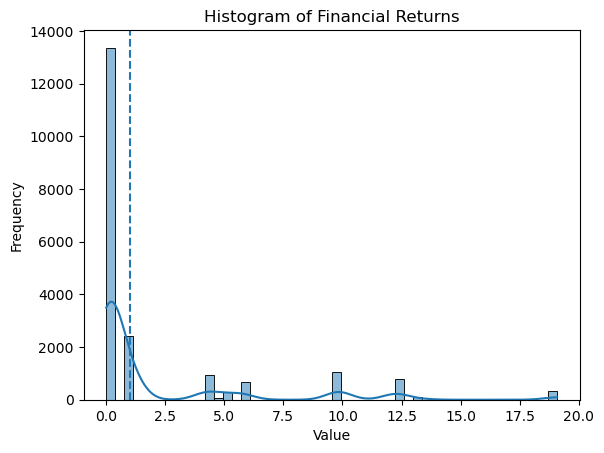

In [18]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=50, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [20]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [73]:
allocation_array

array([0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667,
       0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667, 0.0667])

In [74]:
compute_objective_via_analytical(x=allocation_array,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 event=event_favorable,
                                 df_prob=df)

-0.5966831092291014

In [23]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [13]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               event=event_favorable,
                               df_prob=df)

Optimization terminated successfully.
         Current function value: -1.691665
         Iterations: 6
         Function evaluations: 272
         Gradient evaluations: 17


In [14]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

2.2668526474811657e-05
0.9999999999999999


In [15]:
solution

array([0.14905274, 0.0068798 , 0.00129588, 0.50750173, 0.14905257,
       0.00690143, 0.00163466, 0.00677314, 0.00129588, 0.00701102,
       0.00163466, 0.14528758, 0.00703324, 0.00701102, 0.00163466])

In [16]:
odds_sample = odds_sample[['Market', 'Scenario', 'Bet', 'Sportsbook', 'Odd', 'public_prob', 'real_prob']].assign(solution=solution).sort_values(['solution'], ascending=False)
odds_sample
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Market,Scenario,Bet,Sportsbook,Odd,public_prob,real_prob,solution
3,over/under,1.5,under,LVBET,2.70,0.370370,0.3753,0.507502
0,over/under,2.5,over,Bet365,2.75,0.363636,0.3690,0.149053
4,over/under,2.5,over,Betsson,2.75,0.363636,0.3690,0.149053
11,over/under,2.5,over,Betclic,2.73,0.366300,0.3690,0.145288
12,over/under,3.5,over,Betclic,5.40,0.185185,0.1874,0.007033
13,over/under,3.5,over,NordicBet,5.45,0.183486,0.1874,0.007011
9,over/under,3.5,over,Betsafe,5.45,0.183486,0.1874,0.007011
5,over/under,3.5,over,Betsson,5.70,0.175439,0.1874,0.006901
1,over/under,3.5,over,Bet365,5.75,0.173913,0.1874,0.006880
7,over/under,3.5,over,Betfair,6.00,0.166667,0.1874,0.006773


In [22]:
teste = odds_sample.loc[[0, 4, 11, 1, 5, 9, 12, 13, 2, 8, 7]]
sum(teste['Odd'] * teste['solution'])

1.4840529585770648